In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import xgboost as xgb
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Single time run: to download data sets from kaggle

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d datasnaek/mbti-type
!unzip mbti-type.zip

 70% 17.0M/24.4M [00:00<00:00, 86.7MB/s]
100% 24.4M/24.4M [00:00<00:00, 107MB/s] 
Archive:  mbti-type.zip
  inflating: mbti_1.csv              


In [ ]:
!kaggle datasets download -d mazlumi/mbti-personality-type-twitter-dataset
!unzip mbti-personality-type-twitter-dataset.zip

 37% 12.0M/32.7M [00:00<00:00, 55.5MB/s]
100% 32.7M/32.7M [00:00<00:00, 101MB/s] 
Archive:  mbti-personality-type-twitter-dataset.zip
  inflating: twitter_MBTI.csv        


Feature extraction part 1

In [ ]:
df_2 = pd.read_csv('/content/twitter_MBTI.csv')
df_1 = pd.read_csv('/content/mbti_1.csv')

In [ ]:
# Reformatting df_2 to match df_1 metadata
df_3 = df_2[['label','text']].copy()
df_3['label'] = df_3['label'].str.upper()
df_3.columns = ['type', 'posts']

In [ ]:
df_4 = df_3[df_3.type.isin([ 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'ENTJ',
       'ISTJ', 'ENFJ', 'ISFJ', 'ESTP', 'ESFP', 'ESFJ', 'ESTJ'])]
df_train = pd.concat([df_1,df_4])
df_train.size-df_1.size

7760

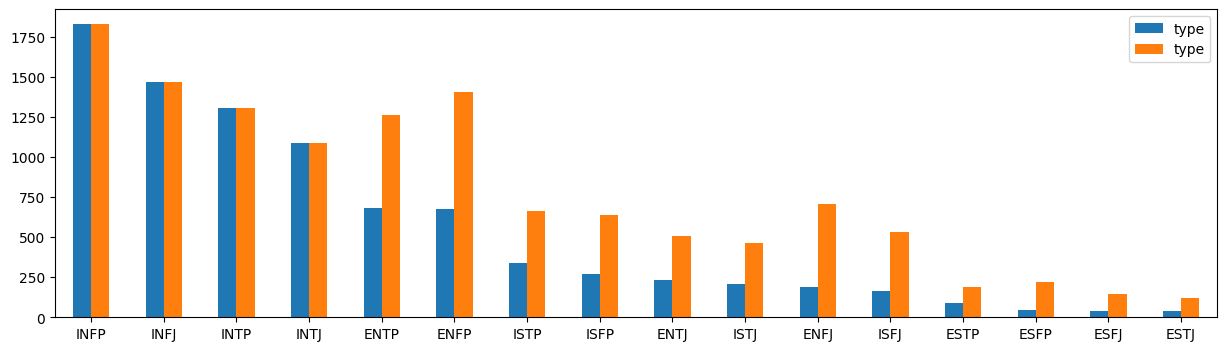

In [ ]:
cnt_srs_1 = df_1['type'].value_counts()
cnt_srs_2 = df_3['type'].value_counts()
cnt_srs_21 = cnt_srs_2.copy()
cnt_srs_21[['INFP','INFJ','INTJ','INTP']] = 0
cnt_srs_final = cnt_srs_1+cnt_srs_21
cnt_srs_final.sort_values(inplace=True,ascending=False)
cnt_df = pd.concat([cnt_srs_1,cnt_srs_final],axis=1)
cnt_df.plot.bar(rot=0,figsize=(15, 4));

In [ ]:
# From kaggle: add words per comment/variance of word counts
#We are using 50 to find the mean words per comment as there are 50 comments in each record that is if we have 100 records for a class
# we have 5000 records generated by that particular user. So the count is essentially the number of users of the data type and each user has 50 oberservations/comments
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

def mean_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.mean(l)

def count_row(row,char):
    l = []
    for i in row.split('|||'):
        l.append(i.count(char))
    return np.mean(l)

# add features:
df_train['words_per_comment'] = df_train['posts'].apply(lambda x: mean_row(x))
df_train['variance_of_word_counts'] = df_train['posts'].apply(lambda x: var_row(x))

df_train['http_per_comment'] = df_train['posts'].apply(lambda x: count_row(x,'http'))
df_train['jpg_per_comment'] = df_train['posts'].apply(lambda x: count_row(x,'jpg'))
df_train['jpeg_per_comment'] = df_train['posts'].apply(lambda x: count_row(x,'jpeg'))
df_train['png_per_comment'] = df_train['posts'].apply(lambda x: count_row(x,'png'))
df_train['img_per_comment'] = df_train['png_per_comment'] + df_train['jpeg_per_comment'] + df_train['jpg_per_comment']

df_train['qm_per_comment'] = df_train['posts'].apply(lambda x: count_row(x,'?'))
df_train['excl_per_comment'] = df_train['posts'].apply(lambda x: count_row(x,'!'))
df_train['ellipsis_per_comment'] = df_train['posts'].apply(lambda x: count_row(x,'...'))

df_train['EI'] = df_train['type'].apply(lambda x: x.count('E'))
# df_train['I'] = df_train['type'].apply(lambda x: x.count('I'))

df_train['SN'] = df_train['type'].apply(lambda x: x.count('S'))
# df_train['N'] = df_train['type'].apply(lambda x: x.count('N'))

df_train['FT'] = df_train['type'].apply(lambda x: x.count('F'))
# df_train['T'] = df_train['type'].apply(lambda x: x.count('T'))

df_train['PJ'] = df_train['type'].apply(lambda x: x.count('P'))
# df_train['J'] = df_train['type'].apply(lambda x: x.count('J'))

# # Parts of speech
# nlp = spacy.load('en')
# tag_dict
# df_train
# df_train['nouns_per_comment'] = df_train['posts'].apply(lambda x: nouns_row(x))
# df_train['adjs_per_comment'] = df_train['posts'].apply(lambda x: adjs_row(x))
# df_train['advs_per_comment'] = df_train['posts'].apply(lambda x: advs_row(x))
# df_train['adps_per_comment'] = df_train['posts'].apply(lambda x: adps_row(x))
# df_train['conjs_per_comment'] = df_train['posts'].apply(lambda x: conjs_row(x))
# df_train['articles_per_comment'] = df_train['posts'].apply(lambda x: articles_row(x))
# df_train['prop_nouns_per_comment'] = df_train['posts'].apply(lambda x: prop_nouns_row(x))
# df_train['verbs_per_comment'] = df_train['posts'].apply(lambda x: verbs_row(x))
# df_train['numerals_per_comment'] = df_train['posts'].apply(lambda x: numerals_row(x))
# df_train['preps_per_comment'] = df_train['posts'].apply(lambda x: preps_row(x))
# df_train['intjecs_per_comment'] = df_train['posts'].apply(lambda x: intjecs_row(x))
# df_train['puncts_per_comment'] = df_train['posts'].apply(lambda x: puncts_row(x))

df_train.head()

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,jpg_per_comment,jpeg_per_comment,png_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,EI,SN,FT,PJ
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,12.10,135.2900,0.48,0.12,0.0,0.00,0.12,0.36,0.06,0.30,0,0,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,24.38,187.4756,0.20,0.02,0.0,0.14,0.16,0.10,0.00,0.38,1,0,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,17.70,180.6900,0.10,0.00,0.0,0.00,0.00,0.24,0.08,0.26,0,0,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",22.26,181.8324,0.04,0.00,0.0,0.00,0.00,0.22,0.06,0.52,0,0,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,20.32,196.4576,0.12,0.04,0.0,0.00,0.04,0.20,0.02,0.42,1,0,0,0


In [ ]:
def wtyp_row(row):
  num_nons = 0
  num_adjs = 0
  num_prps = 0
  num_ints = 0
  num_dets = 0
  num_vrbs = 0
  for i in row.split('|||'):
    i = nltk.re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", i)
    tags = nltk.pos_tag(i)
    for word,tag in tags:
      if tag == 'NN':
        num_nons += 1
      elif tag == 'JJ':
        num_adjs += 1
      elif tag == 'PRP':
        num_prps += 1
      elif tag == 'UH':
        num_ints += 1
      elif tag == 'DT':
        num_dets += 1
      elif re.search(r"(VB[D|G|Z|P|N]*)", tag):
        num_vrbs += 1
  return [num_nons, num_adjs,num_prps,num_ints,num_dets,num_vrbs]

In [ ]:
df_train['nouns_per_comment']=0
df_train['adjs_per_comment']=0
df_train['verbs_per_comment']=0
df_train['prepositions_per_comment']=0
df_train['interjections_per_comment']=0
df_train['determiners_per_comment']=0

In [ ]:
df_train[['nouns_per_comment','adjs_per_comment','prepositions_per_comment','interjections_per_comment','determiners_per_comment','verbs_per_comment']] = df_train['posts'].apply(lambda x: pd.Series(wtyp_row(x)))

In [ ]:
df_train['comment_count'] = df_train['posts'].apply(lambda x: len(x.split('|||')))

In [ ]:
df_train['nouns_per_comment'] = df_train['nouns_per_comment']/df_train['comment_count']
df_train['adjs_per_comment'] = df_train['adjs_per_comment']/df_train['comment_count']
df_train['prepositions_per_comment'] = df_train['prepositions_per_comment']/df_train['comment_count']
df_train['interjections_per_comment'] = df_train['interjections_per_comment']/df_train['comment_count']
df_train['determiners_per_comment'] = df_train['determiners_per_comment']/df_train['comment_count']
df_train['verbs_per_comment'] = df_train['verbs_per_comment']/df_train['comment_count']

In [ ]:
df_train.to_csv('checkpoint1.csv')

In [ ]:
#Sentiment part 1

In [ ]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
# remove non-alphanumeric characters
def clean_text(text):
  '''
  Replace various text patterns with a single space
  '''
  # remove username mentions
  text = re.sub(r"@[A-Za-z0-9]+", "", text)

  # remove mentioned URLs
  text = re.sub(r"\w+:\/\/\S+", "", text)

  # remove stop words
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)

  # remove non-alphanumeric characters
  text = re.sub(r'[^a-zA-Z0-9]', '', text)

  filtered_list = []

  for word in word_tokens:
    if word.lower() not in stop_words:
      filtered_list.append(word)

  # join filtered words into one string
  cleaned_text = ' '.join(filtered_list)

  return cleaned_text

In [ ]:
def get_sentiment(text):
  '''
  Classifies text based on its cumulative sentiment value.
  Parameters:
    text: cleaned text
  Returns:
    polarity_score: int: cumulative polarity score of text
    sentiment: str: positive, neutral, or negative text
  '''
  sia = SentimentIntensityAnalyzer()

  # get individual and compound scores
  individual_scores = sia.polarity_scores(text)
  compound_score = individual_scores['compound']

  if compound_score >= 0.6:
      sentiment = 'Strong Positive'
  elif 0 < compound_score < 0.6:
      sentiment = 'Positive'
  elif -0.6 < compound_score < 0:
      sentiment = 'Negative'
  elif compound_score <= -0.6:
      sentiment = 'Strong Negative'
  else:
      sentiment = 'Neutral'

  return sentiment, compound_score

In [ ]:
# clean posts text
df_train['cleaned_posts'] = df_train['posts'].apply(clean_text)

In [ ]:
df_train[['Sentiment', 'Compound Score']] = df_train['cleaned_posts'].apply(lambda x: pd.Series(get_sentiment(x)))

In [ ]:
df_train.to_csv('checkpoint2.csv')

In [ ]:
df_train.head(3)

,type,posts,words_per_comment,variance_of_word_counts,http_per_comment,jpg_per_comment,jpeg_per_comment,png_per_comment,img_per_comment,qm_per_comment,...,nouns_per_comment,adjs_per_comment,verbs_per_comment,prepositions_per_comment,interjections_per_comment,determiners_per_comment,comment_count,cleaned_posts,Sentiment,Compound Score
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,12.10,135.2900,0.48,0.12,0.0,0.00,0.12,0.36,...,0.465827,0.145683,0.154676,0.048561,0.000000,0.095324,556,' intj moments sportscenter top ten plays pran...,Strong Positive,0.9955
1,ENTP,'I'm finding the lack of me in these posts ver...,24.38,187.4756,0.20,0.02,0.0,0.14,0.16,0.10,...,0.170085,0.090598,0.200000,0.116239,0.001709,0.078632,1170,' 'm finding lack posts alarming.|||Sex boring...,Strong Positive,0.9985
2,INTP,'Good one _____ https://www.youtube.com/wat...,17.70,180.6900,0.10,0.00,0.0,0.00,0.00,0.24,...,0.161483,0.100478,0.185407,0.078947,0.004785,0.065789,836,"'Good one _____ course , say know ; 's blessin...",Strong Positive,0.9987


In [ ]:
data = pd.read_csv("checkpoint2.csv")

# encoding the 'sentiment' column
data['Sentiment_Code'] = data['Sentiment'].astype('category').cat.codes

# displaying the sentiment and their corresponding integers
sentiment_mapping = dict(enumerate(data['Sentiment'].astype('category').cat.categories))
print("Sentiment Mapping:")
for code, sentiment in sentiment_mapping.items():
    print(f"{sentiment}: {code}")

# dropping columns containing text
data.drop(['Unnamed: 0', 'posts', 'cleaned_posts', 'Sentiment'], axis=1, inplace=True)



Sentiment Mapping:
Negative: 0
Neutral: 1
Positive: 2
Strong Negative: 3
Strong Positive: 4


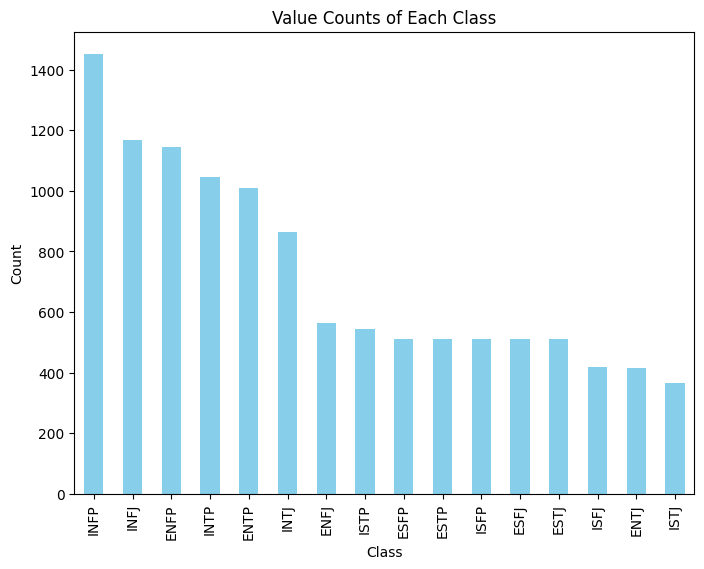

In [ ]:
X = data.drop('type', axis=1)  # Features
y = data['type']  # Target


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# columns to drop in X_train
col_drop = ['EI', 'SN', 'FT', 'PJ']
smote_X = X_train.drop(col_drop, axis=1)
smote_Y = y_train

# minority classes that needs to be oversampled
minority_classes = ['ESTP', 'ESFP', 'ESFJ', 'ESTJ', 'ISFP']

# filtering rows corresponding to minority classes
minority_rows = smote_Y.isin(minority_classes)
X_minority = smote_X[minority_rows]
Y_minority = smote_Y[minority_rows]

# Applying SMOTE to the minority classes
smote = SMOTE(sampling_strategy='auto', random_state=2)
X_OS, Y_OS = smote.fit_resample(X_minority, Y_minority)

# Create a combined DataFrame with both majority and oversampled minority data
combined_X = pd.concat([smote_X[~minority_rows], pd.DataFrame(X_OS, columns=smote_X.columns)])
combined_Y = pd.concat([smote_Y[~minority_rows], pd.Series(Y_OS, name='type')])

# Combine features and target labels into a single DataFrame
combined_data_train = pd.concat([combined_X, combined_Y], axis=1)

# Assuming 'type' is the column representing the target labels in smote_df
class_counts = combined_data_train['type'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts of Each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
# splitting the target label into four seperare independent variables
combined_data_train['EI'] = combined_data_train['type'].str[0].map({'I': 0, 'E': 1})
combined_data_train['SN'] = combined_data_train['type'].str[1].map({'N': 0, 'S': 1})
combined_data_train['FT'] = combined_data_train['type'].str[2].map({'T': 0, 'F': 1})
combined_data_train['PJ'] = combined_data_train['type'].str[3].map({'J': 0, 'P': 1})

# Display the updated DataFrame
combined_data_train.head()

,words_per_comment,variance_of_word_counts,http_per_comment,jpg_per_comment,jpeg_per_comment,png_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,...,interjections_per_comment,determiners_per_comment,comment_count,Compound Score,Sentiment_Code,type,EI,SN,FT,PJ
4095,28.78,145.0516,0.040,0.00,0.0,0.0,0.00,0.22,0.14,0.80,...,0.001439,0.070504,1390,0.9967,4,INFJ,0,0,1,0
5625,32.80,54.0800,0.020,0.00,0.0,0.0,0.00,0.14,0.62,0.86,...,0.000629,0.084852,1591,0.9996,4,INFJ,0,0,1,0
1354,26.28,148.4016,0.040,0.02,0.0,0.0,0.02,0.16,0.10,0.56,...,0.000791,0.094862,1265,0.9994,4,INFJ,0,0,1,0
3344,22.85,173.4275,0.025,0.00,0.0,0.0,0.00,0.35,0.15,0.55,...,0.005714,0.082286,875,0.9993,4,ENFP,1,0,1,1
4682,31.52,58.9296,0.000,0.00,0.0,0.0,0.00,0.32,0.08,0.96,...,0.003929,0.077931,1527,-0.8742,3,INTJ,0,0,0,0


In [ ]:
# combining the label and features into a single dataframe for the test data
combined_test_data = pd.concat([X_test, y_test], axis=1)

XGBoost/Random Forest/Gaussian NB

In [ ]:
# !pip install -q xgboost
import xgboost as xgb

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [ ]:
import sklearn.metrics

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,matthews_corrcoef

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
from seaborn import heatmap

In [ ]:
df_train_no_smote = pd.read_csv('checkpoint2.csv')

In [ ]:
df_train = pd.read_csv('checkpoint_3_train.csv')
df_test = pd.read_csv('checkpoint_3_test.csv')

In [ ]:
X_train_no_smote, X_test_no_smote, y_train_no_smote, y_test_no_smote = train_test_split(df_train_no_smote[['words_per_comment', 'variance_of_word_counts', 'http_per_comment','img_per_comment', 'qm_per_comment', 'excl_per_comment',
       'ellipsis_per_comment', 'nouns_per_comment', 'adjs_per_comment',
       'verbs_per_comment', 'prepositions_per_comment',
       'interjections_per_comment', 'determiners_per_comment','Compound Score']], df_train_no_smote[['EI','SN','FT','PJ']], test_size=0.2, random_state=2)

In [ ]:
train_X = df_train[['words_per_comment', 'variance_of_word_counts', 'http_per_comment','img_per_comment', 'qm_per_comment', 'excl_per_comment',
       'ellipsis_per_comment', 'nouns_per_comment', 'adjs_per_comment',
       'verbs_per_comment', 'prepositions_per_comment',
       'interjections_per_comment', 'determiners_per_comment','Compound Score']]

train_Y = df_train[['EI','SN','FT','PJ']]

test_X = df_test[['words_per_comment', 'variance_of_word_counts', 'http_per_comment','img_per_comment', 'qm_per_comment', 'excl_per_comment',
       'ellipsis_per_comment', 'nouns_per_comment', 'adjs_per_comment',
       'verbs_per_comment', 'prepositions_per_comment',
       'interjections_per_comment', 'determiners_per_comment','Compound Score']]

test_Y = df_test[['EI','SN','FT','PJ']]

In [ ]:
X_train_no_compound = X_train_no_smote[['words_per_comment', 'variance_of_word_counts', 'http_per_comment','img_per_comment', 'qm_per_comment', 'excl_per_comment',
       'ellipsis_per_comment', 'nouns_per_comment', 'adjs_per_comment',
       'verbs_per_comment', 'prepositions_per_comment',
       'interjections_per_comment', 'determiners_per_comment']]

X_test_no_compound = X_test_no_smote[['words_per_comment', 'variance_of_word_counts', 'http_per_comment','img_per_comment', 'qm_per_comment', 'excl_per_comment',
       'ellipsis_per_comment', 'nouns_per_comment', 'adjs_per_comment',
       'verbs_per_comment', 'prepositions_per_comment',
       'interjections_per_comment', 'determiners_per_comment']]

<Axes: >

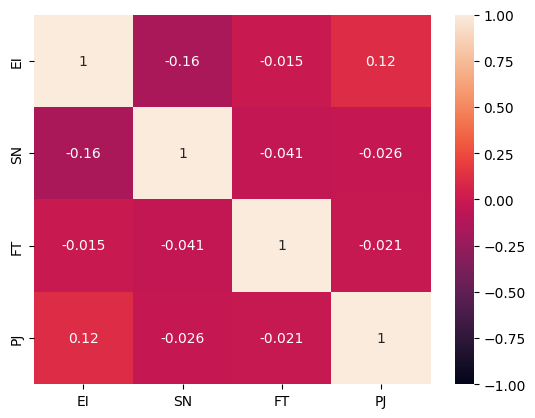

In [ ]:
heatmap(df_train_no_smote[['EI','SN','FT','PJ']].corr(), vmin=-1, vmax=1, annot=True)

In [ ]:
mbti_df = pd.concat([df_train,df_test])

In [ ]:
mbti_df_X = mbti_df[['words_per_comment', 'variance_of_word_counts', 'http_per_comment','img_per_comment', 'qm_per_comment', 'excl_per_comment',
       'ellipsis_per_comment', 'nouns_per_comment', 'adjs_per_comment',
       'verbs_per_comment', 'prepositions_per_comment',
       'interjections_per_comment', 'determiners_per_comment','Compound Score']]

mbti_df_Y = mbti_df[['EI','SN','FT','PJ']]

In [ ]:
scoring = {'accuracy' : make_scorer(accuracy_score),
           'mcc' : make_scorer(matthews_corrcoef),
           'precision' : make_scorer(precision_score,average='macro'),
           'recall' : make_scorer(recall_score,average='macro'),
           'f1_score' : make_scorer(f1_score,average='macro'),
           'roc_auc_score' : make_scorer(roc_auc_score,average='macro')}

Random Forest Classifier

In [ ]:
kfold = KFold(n_splits=10)#, random_state=42)
model_no_compound =RandomForestClassifier(n_estimators=10)
model_no_smote=RandomForestClassifier(n_estimators=10)
model=RandomForestClassifier(n_estimators=10)

In [ ]:
X_train_no_compound.head()

,words_per_comment,variance_of_word_counts,http_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,nouns_per_comment,adjs_per_comment,verbs_per_comment,prepositions_per_comment,interjections_per_comment,determiners_per_comment
4095,28.78,145.0516,0.040,0.00,0.22,0.14,0.80,0.123741,0.071223,0.220863,0.109353,0.001439,0.070504
5625,32.80,54.0800,0.020,0.00,0.14,0.62,0.86,0.140792,0.091138,0.203646,0.106223,0.000629,0.084852
1354,26.28,148.4016,0.040,0.02,0.16,0.10,0.56,0.174704,0.075889,0.214229,0.098814,0.000791,0.094862
3344,22.85,173.4275,0.025,0.00,0.35,0.15,0.55,0.141714,0.074286,0.166857,0.097143,0.005714,0.082286
4682,31.52,58.9296,0.000,0.00,0.32,0.08,0.96,0.144728,0.082515,0.212836,0.060249,0.003929,0.077931


In [ ]:
model_no_compound =RandomForestClassifier(n_estimators=10)
results_no_compound = []
results_no_compound.append(cross_validate(estimator=model,
                                          X=X_train_no_compound,
                                          y=y_train_no_smote['EI'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_compound =RandomForestClassifier(n_estimators=10)
results_no_compound.append(cross_validate(estimator=model,
                                          X=X_train_no_compound,
                                          y=y_train_no_smote['SN'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_compound =RandomForestClassifier(n_estimators=10)
results_no_compound.append(cross_validate(estimator=model,
                                          X=X_train_no_compound,
                                          y=y_train_no_smote['FT'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_compound =RandomForestClassifier(n_estimators=10)
results_no_compound.append(cross_validate(estimator=model,
                                          X=X_train_no_compound,
                                          y=y_train_no_smote['PJ'],
                                          cv=kfold,
                                          scoring=scoring))
print(results_no_compound)

[{'fit_time': array([0.32344866, 0.32002211, 0.48627234, 0.7535212 , 0.69693184,
       0.52803588, 0.4717257 , 0.60106182, 0.31421065, 0.31775379]), 'score_time': array([0.01483655, 0.01454782, 0.02289033, 0.02646637, 0.05501533,
       0.02583408, 0.02875423, 0.01435113, 0.01391387, 0.01619935]), 'test_accuracy': array([0.71044776, 0.73034826, 0.71343284, 0.70049751, 0.71015936,
       0.70717131, 0.70916335, 0.72211155, 0.69521912, 0.72211155]), 'test_mcc': array([0.33549849, 0.37424612, 0.36162026, 0.33745932, 0.3357401 ,
       0.34759702, 0.33433704, 0.38623903, 0.30156748, 0.35228034]), 'test_precision': array([0.68915029, 0.71072657, 0.69915602, 0.68924303, 0.68592297,
       0.68851977, 0.68525896, 0.71595975, 0.67216813, 0.6965217 ]), 'test_recall': array([0.64876958, 0.66616338, 0.66415423, 0.65043988, 0.65157005,
       0.66022682, 0.6508446 , 0.6726949 , 0.63205543, 0.65787243]), 'test_f1_score': array([0.65463877, 0.67459368, 0.66989051, 0.65412228, 0.65771404,
       0.6

In [ ]:
model_no_compound =RandomForestClassifier(n_estimators=10)
results_with_smote = []
results_with_smote.append(cross_validate(estimator=model,
                                          X=train_X,
                                          y=train_Y['EI'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_compound =RandomForestClassifier(n_estimators=10)
results_with_smote.append(cross_validate(estimator=model,
                                          X=train_X,
                                          y=train_Y['SN'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_compound =RandomForestClassifier(n_estimators=10)
results_with_smote.append(cross_validate(estimator=model,
                                          X=train_X,
                                          y=train_Y['FT'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_compound =RandomForestClassifier(n_estimators=10)
results_with_smote.append(cross_validate(estimator=model,
                                          X=train_X,
                                          y=train_Y['PJ'],
                                          cv=kfold,
                                          scoring=scoring))
print(results_no_compound)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py", line 572, in roc_auc_score
    return _average_binary_sco

[{'fit_time': array([0.32344866, 0.32002211, 0.48627234, 0.7535212 , 0.69693184,
       0.52803588, 0.4717257 , 0.60106182, 0.31421065, 0.31775379]), 'score_time': array([0.01483655, 0.01454782, 0.02289033, 0.02646637, 0.05501533,
       0.02583408, 0.02875423, 0.01435113, 0.01391387, 0.01619935]), 'test_accuracy': array([0.71044776, 0.73034826, 0.71343284, 0.70049751, 0.71015936,
       0.70717131, 0.70916335, 0.72211155, 0.69521912, 0.72211155]), 'test_mcc': array([0.33549849, 0.37424612, 0.36162026, 0.33745932, 0.3357401 ,
       0.34759702, 0.33433704, 0.38623903, 0.30156748, 0.35228034]), 'test_precision': array([0.68915029, 0.71072657, 0.69915602, 0.68924303, 0.68592297,
       0.68851977, 0.68525896, 0.71595975, 0.67216813, 0.6965217 ]), 'test_recall': array([0.64876958, 0.66616338, 0.66415423, 0.65043988, 0.65157005,
       0.66022682, 0.6508446 , 0.6726949 , 0.63205543, 0.65787243]), 'test_f1_score': array([0.65463877, 0.67459368, 0.66989051, 0.65412228, 0.65771404,
       0.6

In [ ]:
model_no_smote =RandomForestClassifier(n_estimators=10)
results_no_smote = []
results_no_smote.append(cross_validate(estimator=model,
                                          X=X_train_no_smote,
                                          y=y_train_no_smote['EI'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_smote =RandomForestClassifier(n_estimators=10)
results_no_smote.append(cross_validate(estimator=model,
                                          X=X_train_no_smote,
                                          y=y_train_no_smote['SN'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_smote =RandomForestClassifier(n_estimators=10)
results_no_smote.append(cross_validate(estimator=model,
                                          X=X_train_no_smote,
                                          y=y_train_no_smote['FT'],
                                          cv=kfold,
                                          scoring=scoring))

model_no_smote =RandomForestClassifier(n_estimators=10)
results_no_smote.append(cross_validate(estimator=model,
                                          X=X_train_no_smote,
                                          y=y_train_no_smote['PJ'],
                                          cv=kfold,
                                          scoring=scoring))
print(results_no_compound)

[{'fit_time': array([0.32344866, 0.32002211, 0.48627234, 0.7535212 , 0.69693184,
       0.52803588, 0.4717257 , 0.60106182, 0.31421065, 0.31775379]), 'score_time': array([0.01483655, 0.01454782, 0.02289033, 0.02646637, 0.05501533,
       0.02583408, 0.02875423, 0.01435113, 0.01391387, 0.01619935]), 'test_accuracy': array([0.71044776, 0.73034826, 0.71343284, 0.70049751, 0.71015936,
       0.70717131, 0.70916335, 0.72211155, 0.69521912, 0.72211155]), 'test_mcc': array([0.33549849, 0.37424612, 0.36162026, 0.33745932, 0.3357401 ,
       0.34759702, 0.33433704, 0.38623903, 0.30156748, 0.35228034]), 'test_precision': array([0.68915029, 0.71072657, 0.69915602, 0.68924303, 0.68592297,
       0.68851977, 0.68525896, 0.71595975, 0.67216813, 0.6965217 ]), 'test_recall': array([0.64876958, 0.66616338, 0.66415423, 0.65043988, 0.65157005,
       0.66022682, 0.6508446 , 0.6726949 , 0.63205543, 0.65787243]), 'test_f1_score': array([0.65463877, 0.67459368, 0.66989051, 0.65412228, 0.65771404,
       0.6

In [ ]:
outputs = ['EI','SN','FT','PJ']
without_smote = []
with_smote = []
for i in range(len(outputs)):
  print(outputs[i],'Results without smote:',np.mean(results_no_compound[i]['test_f1_score']))
  without_smote.append(np.mean(results_no_compound[i]['test_f1_score']))
  print(outputs[i],'Results with smote   :',np.mean(results_no_smote[i]['test_f1_score']))
  with_smote.append(np.mean(results_no_smote[i]['test_f1_score']))
  print()

EI Results without smote: 0.6651743409882218
EI Results with smote   : 0.6661229737677163

SN Results without smote: 0.5835074682505345
SN Results with smote   : 0.5870961714868411

FT Results without smote: 0.5846735920576436
FT Results with smote   : 0.5966717250128287

PJ Results without smote: 0.5135102851837537
PJ Results with smote   : 0.5177919463970537



In [ ]:
print(np.mean(without_smote))
print(np.mean(with_smote))

0.5867164216200385
0.5919207041661099


In [ ]:
outputs = ['EI','SN','FT','PJ']
without_smote = []
with_smote = []
for i in range(len(outputs)):
  print(outputs[i],'Results without smote:',np.mean(results_no_compound[i]['test_accuracy']))
  without_smote.append(np.mean(results_no_compound[i]['test_accuracy']))
  print(outputs[i],'Results with smote   :',np.mean(results_no_smote[i]['test_accuracy']))
  with_smote.append(np.mean(results_no_smote[i]['test_accuracy']))
  print()

print(np.mean(without_smote))
print(np.mean(with_smote))

EI Results without smote: 0.7120662623139283
EI Results with smote   : 0.7108724306753087

SN Results without smote: 0.764833204495451
SN Results with smote   : 0.7652324037184595

FT Results without smote: 0.5870213672672495
FT Results with smote   : 0.6071265188004202

PJ Results without smote: 0.5324579294761254
PJ Results with smote   : 0.5461003746209194

0.6490946908881885
0.6573329319537768


In [ ]:
outputs = ['EI','SN','FT','PJ']
without_smote = []
with_smote = []
for i in range(len(outputs)):
  print(outputs[i],'Results without smote:',np.mean(results_no_compound[i]['test_roc_auc_score']))
  without_smote.append(np.mean(results_no_compound[i]['test_roc_auc_score']))
  print(outputs[i],'Results with smote   :',np.mean(results_no_smote[i]['test_roc_auc_score']))
  with_smote.append(np.mean(results_no_smote[i]['test_roc_auc_score']))
  print()

print(np.mean(without_smote))
print(np.mean(with_smote))

EI Results without smote: 0.6554791310997119
EI Results with smote   : 0.6556048113229398

SN Results without smote: 0.5752048341177891
SN Results with smote   : 0.579374485962052

FT Results without smote: 0.5870714475757521
FT Results with smote   : 0.6076564192725808

PJ Results without smote: 0.5098432658208396
PJ Results with smote   : 0.524869185361157

0.5818996696535232
0.5918762254796824


In [ ]:
outputs = ['EI','SN','FT','PJ']
without_smote = []
with_smote = []
for i in range(len(outputs)):
  print(outputs[i],'Results without smote:',np.mean(results_no_compound[i]['test_mcc']))
  without_smote.append(np.mean(results_no_compound[i]['test_mcc']))
  print(outputs[i],'Results with smote   :',np.mean(results_no_smote[i]['test_mcc']))
  with_smote.append(np.mean(results_no_smote[i]['test_mcc']))
  print()

EI Results without smote: 0.3466585205211393
EI Results with smote   : 0.34481422057194455

SN Results without smote: 0.21328160058574555
SN Results with smote   : 0.22046235755723242

FT Results without smote: 0.17326676936356375
FT Results with smote   : 0.21432080303519627

PJ Results without smote: 0.01977796814541987
PJ Results with smote   : 0.0498047126659563



In [ ]:
print(np.mean(without_smote))
print(np.mean(with_smote))

0.18824621465396713
0.2073505234575824


In [ ]:
model_no_smote.fit(train_X,train_Y)
model_no_smote.feature_importances_

array([0.0724893 , 0.08533489, 0.05531997, 0.02145769, 0.06682361,
       0.07171008, 0.07677575, 0.0962468 , 0.09479127, 0.06987753,
       0.07244046, 0.06237072, 0.07937962, 0.07498232])

<BarContainer object of 14 artists>

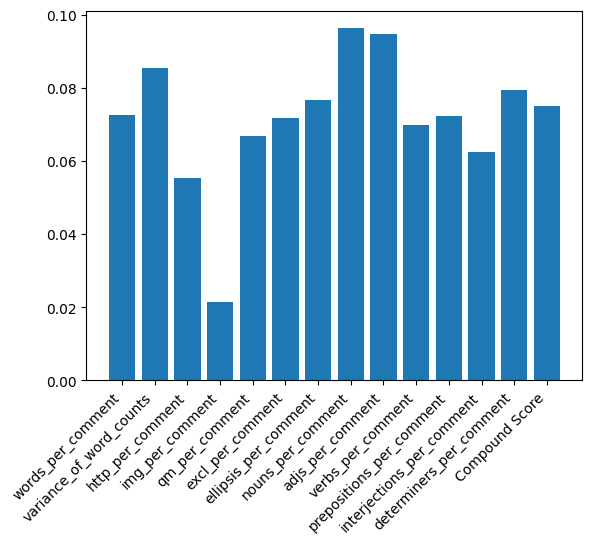

In [ ]:
plt.xticks(rotation=45, ha='right')
plt.bar(train_X.columns,model_no_smote.feature_importances_)

In [ ]:
results = cross_validate(estimator=model,
                                          X=train_X,
                                          y=train_Y,
                                          cv=kfold,
                                          scoring=scoring)
results

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py", line 580, in roc_auc_score
    return _average_binary_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_base.py", line 118, in _average_binary_score
    score[c] = binary_metric(y_true_c, y_score_c, sample_weight=score_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py", line 339, in _binary_

{'fit_time': array([6.33699107, 3.96987939, 3.7088666 , 3.29745746, 2.40079331,
        3.17923999, 3.10706258, 3.46411109, 2.78846693, 2.40965891]),
 'score_time': array([0.09973168, 0.11128211, 0.08914185, 0.06999969, 0.06424451,
        0.09947729, 0.06556273, 0.08479714, 0.06388593, 0.06151509]),
 'test_accuracy': array([0.20761246, 0.21107266, 0.21366782, 0.22058824, 0.22164502,
        0.21991342, 0.21298701, 0.23116883, 0.18008658, 0.32554113]),
 'test_precision': array([0.57469286, 0.56062444, 0.57212953, 0.57165197, 0.56489443,
        0.57493835, 0.5547002 , 0.67041983, 0.82599999, 0.81527721]),
 'test_recall': array([0.61971533, 0.63017201, 0.61660133, 0.61667863, 0.62686761,
        0.60855836, 0.60274302, 0.64550013, 0.65514866, 0.7270561 ]),
 'test_f1_score': array([0.59051417, 0.58695855, 0.58501511, 0.58614069, 0.59167298,
        0.58401887, 0.5711026 , 0.64978565, 0.69901216, 0.72990684]),
 'test_roc_auc_score': array([0.6274442 , 0.62890276, 0.62536002, 0.62170432, 0

In [ ]:
np.nanmean(results['test_accuracy'])

0.21891285292699275

XGBoost

In [ ]:
model_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=10,tree_method="hist")
model_xgb.fit(X_train_no_smote, y_train_no_smote)
pred_Y = model_xgb.predict(X_test_no_smote)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

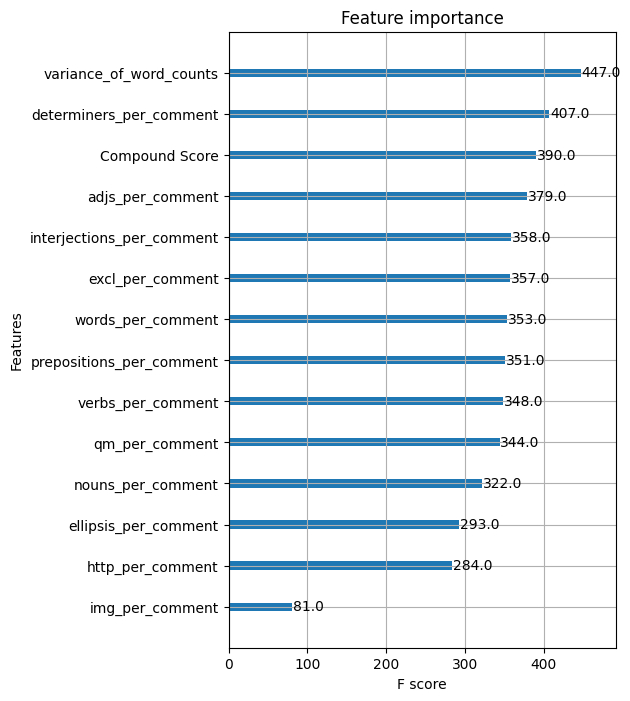

In [ ]:
fig, ax = plt.subplots(figsize=(5,8))
xgb.plot_importance(model_xgb, ax=ax)

In [ ]:
#with smote
print('EI',sklearn.metrics.accuracy_score(test_Y['EI'], pred_Y[:,0]))
print('SN',sklearn.metrics.accuracy_score(test_Y['SN'], pred_Y[:,1]))
print('FT',sklearn.metrics.accuracy_score(test_Y['FT'], pred_Y[:,2]))
print('PJ',sklearn.metrics.accuracy_score(test_Y['PJ'], pred_Y[:,3]))

EI 0.7268020708880923
SN 0.7729988052568698
FT 0.6228594185583433
PJ 0.5675029868578255


In [ ]:
conf_matrix = []
conf_matrix[cnt].append(sklearn.metrics.confusion_matrix(test_Y['EI'], pred_Y[:,0]))
conf_matrix[cnt].append(sklearn.metrics.confusion_matrix(test_Y['SN'], pred_Y[:,1]))
conf_matrix[cnt].append(sklearn.metrics.confusion_matrix(test_Y['FT'], pred_Y[:,2]))
conf_matrix[cnt].append(sklearn.metrics.confusion_matrix(test_Y['PJ'], pred_Y[:,3]))

NameError: ignored

In [ ]:
kfold = KFold(n_splits=10)
conf_matrix = []
cnt = 0
for train,test in kfold.split(mbti_df_X):
  train_X = mbti_df_X.iloc[train]
  train_Y = mbti_df_Y.iloc[train]
  test_X = mbti_df_X.iloc[test]
  test_Y = mbti_df_Y.iloc[test]
  model_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=250,tree_method="hist")
  model_xgb.fit(train_X, train_Y)
  pred_Y = model_xgb.predict(test_X)
  conf_matrix.append([])
  conf_matrix[cnt].append(sklearn.metrics.confusion_matrix(test_Y['EI'], pred_Y[:,0]))
  conf_matrix[cnt].append(sklearn.metrics.confusion_matrix(test_Y['SN'], pred_Y[:,1]))
  conf_matrix[cnt].append(sklearn.metrics.confusion_matrix(test_Y['FT'], pred_Y[:,2]))
  conf_matrix[cnt].append(sklearn.metrics.confusion_matrix(test_Y['PJ'], pred_Y[:,3]))
  cnt += 1

In [ ]:
results1 = cross_validate(estimator=model_xgb,
                                          X=mbti_df_X,
                                          y=mbti_df_Y,
                                          cv=kfold,
                                          scoring=scoring)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py", line 580, in roc_auc_score
    return _average_binary_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_base.py", line 118, in _average_binary_score
    score[c] = binary_metric(y_true_c, y_score_c, sample_weight=score_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py", line 339, in _binary_

In [ ]:
results1

{'fit_time': array([13.3793025 ,  4.40009975, 20.11008906,  4.75980163,  4.41904759,
         7.43150091,  4.37681675,  7.29533887,  4.37800384,  7.45561218]),
 'score_time': array([0.08421373, 0.07032943, 0.10373092, 0.06832933, 0.08280039,
        0.06745696, 0.08063269, 0.06573009, 0.06728506, 0.06896567]),
 'test_accuracy': array([0.18479033, 0.21321962, 0.19545131, 0.19971571, 0.22316986,
        0.21763869, 0.19985775, 0.14864865, 0.22475107, 0.19559033]),
 'test_precision': array([0.5533218 , 0.55912747, 0.54146064, 0.54771754, 0.56366828,
        0.54600277, 0.77182474, 0.79895774, 0.6997    , 0.59206341]),
 'test_recall': array([0.5956037 , 0.59326474, 0.60494329, 0.59030039, 0.58335464,
        0.58632349, 0.63648308, 0.67043417, 0.65717453, 0.5788341 ]),
 'test_f1_score': array([0.56968763, 0.5710413 , 0.56603592, 0.56594506, 0.56795725,
        0.56022994, 0.67891551, 0.68230928, 0.669384  , 0.58013933]),
 'test_roc_auc_score': array([0.61416611, 0.6223494 , 0.61098282, 0.6

In [ ]:
conf_matrix

[[array([[786, 142],
         [227, 252]]),
  array([[1043,  158],
         [ 120,   86]]),
  array([[335, 309],
         [240, 523]]),
  array([[176, 420],
         [200, 611]])],
 [array([[790, 121],
         [222, 274]]),
  array([[1036,  165],
         [ 137,   69]]),
  array([[374, 292],
         [197, 544]]),
  array([[188, 410],
         [201, 608]])],
 [array([[741, 150],
         [242, 274]]),
  array([[1037,  173],
         [ 120,   77]]),
  array([[324, 319],
         [225, 539]]),
  array([[170, 447],
         [164, 626]])],
 [array([[790, 158],
         [206, 253]]),
  array([[1017,  160],
         [ 147,   83]]),
  array([[348, 309],
         [238, 512]]),
  array([[163, 409],
         [195, 640]])],
 [array([[770, 113],
         [241, 283]]),
  array([[1062,  151],
         [ 131,   63]]),
  array([[372, 318],
         [209, 508]]),
  array([[154, 386],
         [208, 659]])],
 [array([[781, 149],
         [242, 234]]),
  array([[1069,  130],
         [ 132,   75]]),
  a

Naive Bayes

In [ ]:
gnb = GaussianNB()
results_gnb = cross_validate(estimator=model_xgb,
                                          X=mbti_df_X,
                                          y=mbti_df_Y,
                                          cv=kfold,
                                          scoring=scoring)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py", line 580, in roc_auc_score
    return _average_binary_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_base.py", line 118, in _average_binary_score
    score[c] = binary_metric(y_true_c, y_score_c, sample_weight=score_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py", line 339, in _binary_

In [ ]:
results_gnb

{'fit_time': array([ 9.90623498,  4.4354074 ,  7.45691061,  4.47998857,  7.45334554,
         4.44591522,  4.43655157,  7.37392426,  4.44528747, 12.27578902]),
 'score_time': array([0.06809187, 0.07122278, 0.06847525, 0.07053757, 0.06778431,
        0.08047342, 0.07082391, 0.06975555, 0.07174659, 0.18935442]),
 'test_accuracy': array([0.18479033, 0.21321962, 0.19545131, 0.19971571, 0.22316986,
        0.21763869, 0.19985775, 0.14864865, 0.22475107, 0.19559033]),
 'test_precision': array([0.5533218 , 0.55912747, 0.54146064, 0.54771754, 0.56366828,
        0.54600277, 0.77182474, 0.79895774, 0.6997    , 0.59206341]),
 'test_recall': array([0.5956037 , 0.59326474, 0.60494329, 0.59030039, 0.58335464,
        0.58632349, 0.63648308, 0.67043417, 0.65717453, 0.5788341 ]),
 'test_f1_score': array([0.56968763, 0.5710413 , 0.56603592, 0.56594506, 0.56795725,
        0.56022994, 0.67891551, 0.68230928, 0.669384  , 0.58013933]),
 'test_roc_auc_score': array([0.61416611, 0.6223494 , 0.61098282, 0.6

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

from sklearn.metrics import roc_auc_score, roc_curve, auc

In [ ]:
# Load data into dataframes
df_train = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_train.csv')
df_test = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_test.csv')

# Separate features (X) and target variable (y) for training set
df1 = df_train
X_train = df_train.drop(['type', 'EI', 'SN', 'FT', 'PJ'], axis=1)
y_train = df1['EI']

# Separate features (X) and target variable (y) for test set
df1 = df_test
X_test = df_test.drop(['type', 'EI', 'SN', 'FT', 'PJ'], axis=1)
y_test = df1['EI']

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM model and train on train model on training set
svm_model = SVC(kernel = 'rbf', C = 1.0)
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
result_df = pd.DataFrame({'Predicted Labels': y_pred})

y_proba = svm_model.decision_function(X_test_scaled)

# Evaluate the models
accuracy_EI = accuracy_score(y_test, result_df)
conf_matrix_EI = confusion_matrix(y_test, result_df)
classification_rep_EI = classification_report(y_test, result_df)
roc_auc_EI = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_curve_EI = auc(fpr, tpr)

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Combine features and target variable for the entire dataset
X_combined = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.columns),
                       pd.DataFrame(X_test_scaled, columns=X_test.columns)], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

# Perform cross-validation and get accuracy scores
cross_val_scores_EI = cross_val_score(svm_model, X_combined, y_combined, cv=kf, scoring=make_scorer(accuracy_score))

print(f" EI Accuracy: {accuracy_EI}")
print(f" EI Confusion Matrix: {conf_matrix_EI}")
print(f" EI Classification Report: {classification_rep_EI}")
print(f"Area under ROC Curve (EI): {roc_auc_EI}")
print(f"Cross-validation scores (EI): {cross_val_scores_EI}")
print(f"Mean Accuracy (EI): {cross_val_scores_EI.mean()}")

In [ ]:
# Load data into dataframes
df_train = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_train.csv')
df_test = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_test.csv')

# Separate features (X) and target variable (y) for training set

df1 = df_train
X_train = df_train.drop(['type', 'EI', 'SN', 'FT', 'PJ'], axis=1)
y_train = df1['SN']

# Separate features (X) and target variable (y) for test set
df1 = df_test
X_test = df_test.drop(['type', 'EI', 'SN', 'FT', 'PJ'], axis=1)
y_test = df1['SN']

# Ensure that columns are in the same order
#X_test = X_test[X_train.columns]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM model (you can choose different kernel functions and adjust parameters)
svm_model = SVC(kernel = 'rbf', C = 1.0)

# Train the SVM model on the training set
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
result_df = pd.DataFrame({'Predicted Labels': y_pred})

# Evaluate the models
accuracy_SN = accuracy_score(y_test, result_df)
conf_matrix_SN = confusion_matrix(y_test, result_df)
classification_rep_SN = classification_report(y_test, result_df)
roc_auc_SN = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc_curve_SN = auc(fpr, tpr)

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Combine features and target variable for the entire dataset
X_combined = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.columns),
                       pd.DataFrame(X_test_scaled, columns=X_test.columns)], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

# Perform cross-validation and get accuracy scores
cross_val_scores_SN = cross_val_score(svm_model, X_combined, y_combined, cv=kf, scoring=make_scorer(accuracy_score))

print(f" SN Accuracy: {accuracy_SN}")
print(f" SN Confusion Matrix: {conf_matrix_SN}")
print(f" SN Classification Report: {classification_rep_SN}")
print(f"Area under ROC Curve (SN): {roc_auc_SN}")
print(f"Cross-validation scores (SN): {cross_val_scores_SN}")
print(f"Mean Accuracy (SN): {cross_val_scores_SN.mean()}")

In [ ]:
# Load data into dataframes
df_train = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_train.csv')
df_test = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_test.csv')

# Separate features (X) and target variable (y) for training set
df1 = df_train
X_train = df_train.drop(['type', 'EI', 'SN', 'FT', 'PJ'], axis=1)
y_train = df1['FT']

# Separate features (X) and target variable (y) for test set
df1 = df_test
X_test = df_test.drop(['type', 'EI', 'SN', 'FT', 'PJ'], axis=1)
y_test = df1['FT']

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM model (you can choose different kernel functions and adjust parameters)
svm_model = SVC(kernel = 'rbf', C = 1.0)

# Train the SVM model on the training set
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
result_df = pd.DataFrame({'Predicted Labels': y_pred})

# Evaluate the models
accuracy_FT = accuracy_score(y_test, result_df)
conf_matrix_FT = confusion_matrix(y_test, result_df)
classification_rep_FT = classification_report(y_test, result_df)
roc_auc_FT = roc_auc_score(y_test, y_proba)
fpr_FT, tpr_FT, _ = roc_curve(y_test, y_proba)
roc_auc_curve_FT = auc(fpr_FT, tpr_FT)

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Combine features and target variable for the entire dataset
X_combined = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.columns),
                       pd.DataFrame(X_test_scaled, columns=X_test.columns)], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

# Perform cross-validation and get accuracy scores
cross_val_scores_FT = cross_val_score(svm_model, X_combined, y_combined, cv=kf, scoring=make_scorer(accuracy_score))

print(f" FT Accuracy: {accuracy_FT}")
print(f" FT Confusion Matrix: {conf_matrix_FT}")
print(f" FT Classification Report: {classification_rep_FT}")
print(f"Area under ROC Curve (FT): {roc_auc_FT}")
print(f"Cross-validation scores (FT): {cross_val_scores_FT}")
print(f"Mean Accuracy (FT): {cross_val_scores_FT.mean()}")

In [ ]:
# Load data into dataframes
df_train = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_train.csv')
df_test = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_train.csv')

# Separate features (X) and target variable (y) for training set
df1 = df_train
X_train = df_train.drop(['type', 'EI', 'SN', 'FT', 'PJ'], axis=1)
y_train = df1['PJ']

# Separate features (X) and target variable (y) for test set
df1 = df_test
X_test = df_test.drop(['type', 'EI', 'SN', 'FT', 'PJ'], axis=1)
y_test = df1['PJ']

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM model (you can choose different kernel functions and adjust parameters)
svm_model = SVC(kernel = 'rbf', C = 1.0)

# Train the SVM model on the training set
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
result_df = pd.DataFrame({'Predicted Labels': y_pred})

# Evaluate the models
accuracy_PJ = accuracy_score(y_test, result_df)
conf_matrix_PJ = confusion_matrix(y_test, result_df)
classification_rep_PJ = classification_report(y_test, result_df)
roc_auc_PJ = roc_auc_score(y_test, y_proba)
#fpr, tpr, _ = roc_curve(y_test, y_proba)
#roc_auc_curve_PJ = auc(fpr, tpr)

# Define k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Combine features and target variable for the entire dataset
X_combined = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.columns),
                       pd.DataFrame(X_test_scaled, columns=X_test.columns)], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

# Perform cross-validation and get accuracy scores
cross_val_scores_PJ = cross_val_score(svm_model, X_combined, y_combined, cv=kf, scoring=make_scorer(accuracy_score))

print(f" PJ Accuracy: {accuracy_PJ}")
print(f" PJ Confusion Matrix: {conf_matrix_PJ}")
print(f" PJ Classification Report: {classification_rep_PJ}")
print(f"Area under ROC Curve (PJ): {roc_auc_PJ}")
print(f"Cross-validation scores (PJ): {cross_val_scores_PJ}")
print(f"Mean Accuracy (PJ): {cross_val_scores_PJ.mean()}")

In [ ]:
df_train3 = pd.read_csv('C:/Users/sreej/Desktop/SML Project/checkpoint_3_train.csv')

In [ ]:
import matplotlib.pyplot as plt

# Assuming df_train is your DataFrame
plt.hist(df_train['Compound Score'], bins=3, color='skyblue', alpha=0.85, rwidth=0.75)
plt.title('Distribution of Compound Score')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

Implementing Logistic Regression

In [ ]:
# getting the dataset
data = pd.read_csv("checkpoint2.csv")

# encoding the 'sentiment' column
data['Sentiment_Code'] = data['Sentiment'].astype('category').cat.codes

# displaying the sentiment and their corresponding integers
sentiment_mapping = dict(enumerate(data['Sentiment'].astype('category').cat.categories))
print("Sentiment Mapping:")
for code, sentiment in sentiment_mapping.items():
    print(f"{sentiment}: {code}")

# dropping columns containing text
data.drop(['Unnamed: 0', 'posts', 'cleaned_posts', 'Sentiment'], axis=1, inplace=True)

Sentiment Mapping:
Negative: 0
Neutral: 1
Positive: 2
Strong Negative: 3
Strong Positive: 4


In [ ]:
# SMOTE analysis
# Features
X = data.drop('type', axis=1)
# Target
y = data['type']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# columns to drop in X_train
col_drop = ['EI', 'SN', 'FT', 'PJ']
smote_X = X_train.drop(col_drop, axis=1)
smote_Y = y_train

# minority classes that needs to be oversampled
minority_classes = ['ESTP', 'ESFP', 'ESFJ', 'ESTJ', 'ISFP']

# filtering rows corresponding to minority classes
minority_rows = smote_Y.isin(minority_classes)
X_minority = smote_X[minority_rows]
Y_minority = smote_Y[minority_rows]

# Applying SMOTE to the minority classes
smote = SMOTE(sampling_strategy='auto')
X_OS, Y_OS = smote.fit_resample(X_minority, Y_minority)

# Create a combined DataFrame with both majority and oversampled minority data
combined_X = pd.concat([smote_X[~minority_rows], pd.DataFrame(X_OS, columns=smote_X.columns)])
combined_Y = pd.concat([smote_Y[~minority_rows], pd.Series(Y_OS, name='type')])

# Combine features and target labels into a single DataFrame
combined_data_train = pd.concat([combined_X, combined_Y], axis=1)



In [ ]:
# splitting the target label into four seperare independent variables
combined_data_train['EI'] = combined_data_train['type'].str[0].map({'I': 0, 'E': 1})
combined_data_train['SN'] = combined_data_train['type'].str[1].map({'N': 0, 'S': 1})
combined_data_train['FT'] = combined_data_train['type'].str[2].map({'T': 0, 'F': 1})
combined_data_train['PJ'] = combined_data_train['type'].str[3].map({'J': 0, 'P': 1})

# Display the updated DataFrame
combined_data_train.head()

,words_per_comment,variance_of_word_counts,http_per_comment,jpg_per_comment,jpeg_per_comment,png_per_comment,img_per_comment,qm_per_comment,excl_per_comment,ellipsis_per_comment,...,interjections_per_comment,determiners_per_comment,comment_count,Compound Score,Sentiment_Code,type,EI,SN,FT,PJ
4095,28.78,145.0516,0.040,0.00,0.0,0.0,0.00,0.22,0.14,0.80,...,0.001439,0.070504,1390,0.9967,4,INFJ,0,0,1,0
5625,32.80,54.0800,0.020,0.00,0.0,0.0,0.00,0.14,0.62,0.86,...,0.000629,0.084852,1591,0.9996,4,INFJ,0,0,1,0
1354,26.28,148.4016,0.040,0.02,0.0,0.0,0.02,0.16,0.10,0.56,...,0.000791,0.094862,1265,0.9994,4,INFJ,0,0,1,0
3344,22.85,173.4275,0.025,0.00,0.0,0.0,0.00,0.35,0.15,0.55,...,0.005714,0.082286,875,0.9993,4,ENFP,1,0,1,1
4682,31.52,58.9296,0.000,0.00,0.0,0.0,0.00,0.32,0.08,0.96,...,0.003929,0.077931,1527,-0.8742,3,INTJ,0,0,0,0


In [ ]:
# combining the label and features into a single dataframe for the test data
combined_test_data = pd.concat([X_test, y_test], axis=1)

In [ ]:
# creating feature data for train
feature_train = combined_data_train.drop(['EI', 'SN', 'FT', 'PJ', 'type'], axis = 1)
# labels for the train dataset
label_train = combined_data_train[['EI', 'SN', 'FT', 'PJ']]

# splitting the target label into four seperare independent variables
combined_test_data['EI'] = combined_test_data['type'].str[0].map({'I': 0, 'E': 1})
combined_test_data['SN'] = combined_test_data['type'].str[1].map({'N': 0, 'S': 1})
combined_test_data['FT'] = combined_test_data['type'].str[2].map({'T': 0, 'F': 1})
combined_test_data['PJ'] = combined_test_data['type'].str[3].map({'J': 0, 'P': 1})

# test data features
feature_test = combined_test_data.drop(['EI', 'SN', 'FT', 'PJ', 'type'], axis = 1)
# test labels
label_test = combined_test_data[['EI', 'SN', 'FT', 'PJ']]

In [ ]:
# Initialize logistic regression models for each label
log_EI = LogisticRegression(max_iter=1000)
log_SN = LogisticRegression(max_iter=1000)
log_FT = LogisticRegression(max_iter=1000)
log_PJ = LogisticRegression(max_iter=1000)

# Train the models
log_EI.fit(feature_train, label_train['EI'])
log_SN.fit(feature_train, label_train['SN'])
log_FT.fit(feature_train, label_train['FT'])
log_PJ.fit(feature_train, label_train['PJ'])

# Make predictions on the test set
pred_EI = log_EI.predict(feature_test)
pred_SN = log_SN.predict(feature_test)
pred_FT = log_FT.predict(feature_test)
pred_PJ = log_PJ.predict(feature_test)

# cross validation
cv_scores_EI = cross_val_score(log_EI, feature_train, label_train['EI'], cv=10, scoring='accuracy')
cv_scores_SN = cross_val_score(log_SN, feature_train, label_train['SN'], cv=10, scoring='accuracy')
cv_scores_FT = cross_val_score(log_FT, feature_train, label_train['FT'], cv=10, scoring='accuracy')
cv_scores_PJ = cross_val_score(log_PJ, feature_train, label_train['PJ'], cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Accuracy for EI: {:.6f}".format(np.mean(cv_scores_EI)))
print("Cross-Validation Accuracy for SN: {:.6f}".format(np.mean(cv_scores_SN)))
print("Cross-Validation Accuracy for FT: {:.6f}".format(np.mean(cv_scores_FT)))
print("Cross-Validation Accuracy for PJ: {:.6f}".format(np.mean(cv_scores_PJ)))

# Evaluate the models
accuracy_EI = accuracy_score(label_test['EI'], pred_EI)
accuracy_SN = accuracy_score(label_test['SN'], pred_SN)
accuracy_FT = accuracy_score(label_test['FT'], pred_FT)
accuracy_PJ = accuracy_score(label_test['PJ'], pred_PJ)

# printing accuracy scores
print(f"\nAccuracy for EI: {accuracy_EI:.6f}")
print(f"Accuracy for SN: {accuracy_SN:.6f}")
print(f"Accuracy for FT: {accuracy_FT:.6f}")
print(f"Accuracy for PJ: {accuracy_PJ:.6f}")

# Calculate F1 scores
f1_scores_EI = f1_score(label_test['EI'], pred_EI, average='binary')
f1_scores_SN = f1_score(label_test['SN'], pred_SN, average='binary')
f1_scores_FT = f1_score(label_test['FT'], pred_FT, average='binary')
f1_scores_PJ = f1_score(label_test['PJ'], pred_PJ, average='binary')

# Print F1 scores
print(f"\nF1 Score for EI: {f1_scores_EI:.6f}")
print(f"F1 Score for SN: {f1_scores_SN:.6f}")
print(f"F1 Score for FT: {f1_scores_FT:.6f}")
print(f"F1 Score for PJ: {f1_scores_PJ:.6f}")


Cross-Validation Accuracy for EI: 0.728925
Cross-Validation Accuracy for SN: 0.720447
Cross-Validation Accuracy for FT: 0.583428
Cross-Validation Accuracy for PJ: 0.587244

Accuracy for EI: 0.727599
Accuracy for SN: 0.753485
Accuracy for FT: 0.611310
Accuracy for PJ: 0.587017

F1 Score for EI: 0.594787
F1 Score for SN: 0.537023
F1 Score for FT: 0.673797
F1 Score for PJ: 0.730999


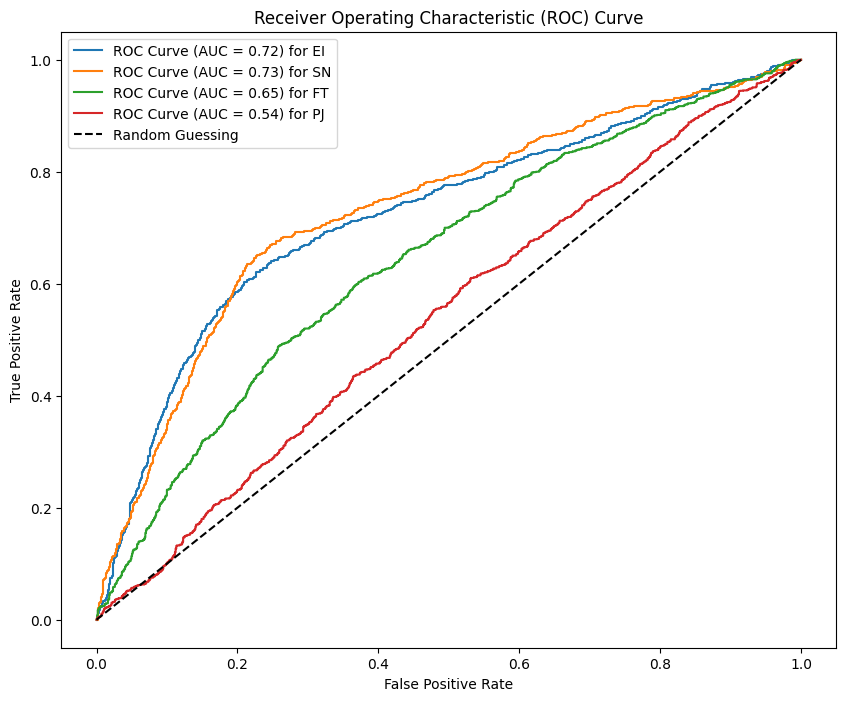

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# probabilities for each label
probs_EI = log_EI.predict_proba(feature_test)[:, 1]
probs_SN = log_SN.predict_proba(feature_test)[:, 1]
probs_FT = log_FT.predict_proba(feature_test)[:, 1]
probs_PJ = log_PJ.predict_proba(feature_test)[:, 1]

# Compute ROC curve
fpr_EI, tpr_EI, _ = roc_curve(label_test['EI'], probs_EI)
fpr_SN, tpr_SN, _ = roc_curve(label_test['SN'], probs_SN)
fpr_FT, tpr_FT, _ = roc_curve(label_test['FT'], probs_FT)
fpr_PJ, tpr_PJ, _ = roc_curve(label_test['PJ'], probs_PJ)

# Compute AUC scores for each label
roc_auc_EI = auc(fpr_EI, tpr_EI)
roc_auc_SN = auc(fpr_SN, tpr_SN)
roc_auc_FT = auc(fpr_FT, tpr_FT)
roc_auc_PJ = auc(fpr_PJ, tpr_PJ)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_EI, tpr_EI, label=f'ROC Curve (AUC = {roc_auc_EI:.2f}) for EI')
plt.plot(fpr_SN, tpr_SN, label=f'ROC Curve (AUC = {roc_auc_SN:.2f}) for SN')
plt.plot(fpr_FT, tpr_FT, label=f'ROC Curve (AUC = {roc_auc_FT:.2f}) for FT')
plt.plot(fpr_PJ, tpr_PJ, label=f'ROC Curve (AUC = {roc_auc_PJ:.2f}) for PJ')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()





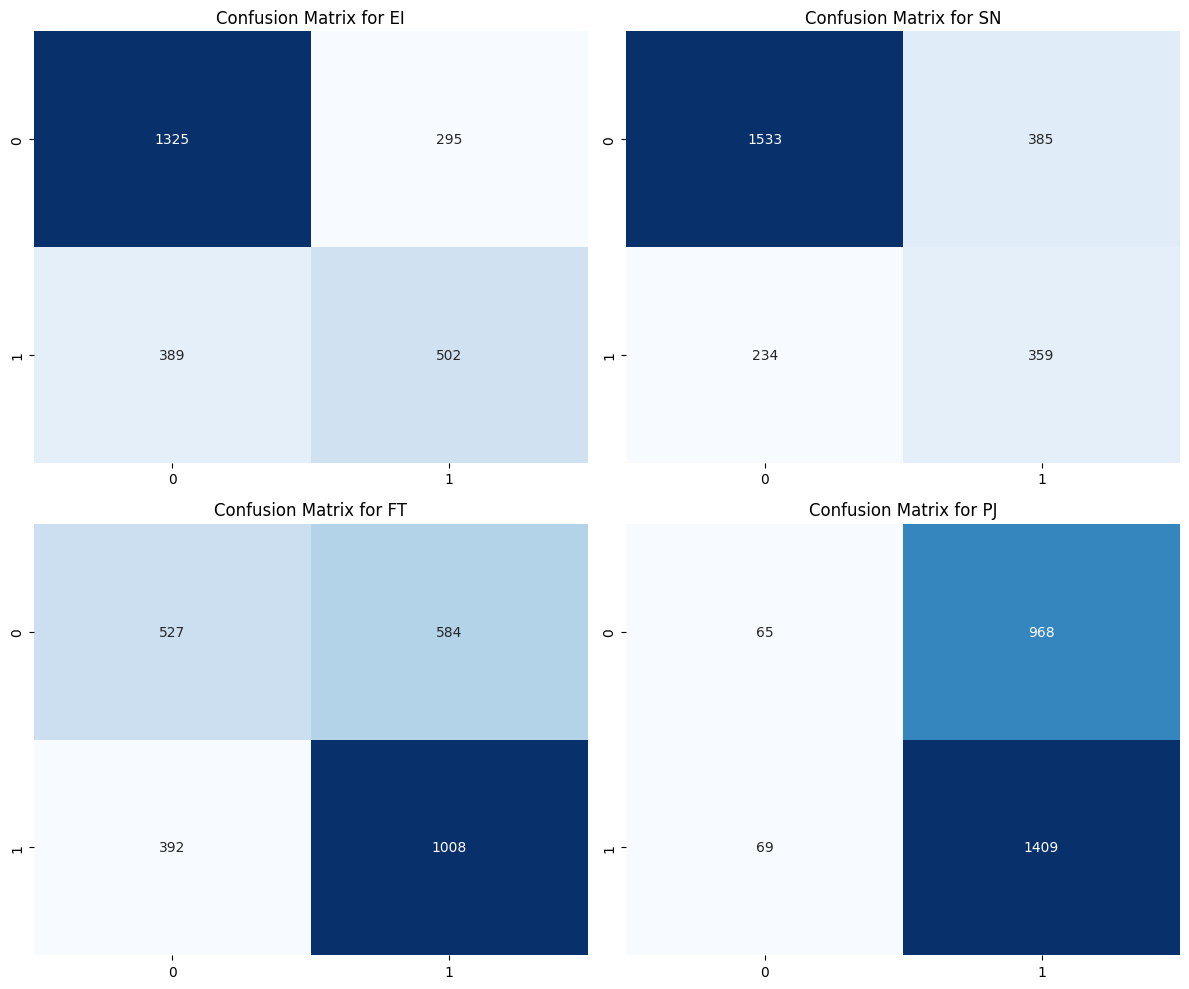

In [ ]:
# confusion matrix for each label
# Compute confusion matrices for each label
cm_EI = confusion_matrix(label_test['EI'], pred_EI)
cm_SN = confusion_matrix(label_test['SN'], pred_SN)
cm_FT = confusion_matrix(label_test['FT'], pred_FT)
cm_PJ = confusion_matrix(label_test['PJ'], pred_PJ)

# Plot confusion matrices
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(cm_EI, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for EI')

plt.subplot(2, 2, 2)
sns.heatmap(cm_SN, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for SN')

plt.subplot(2, 2, 3)
sns.heatmap(cm_FT, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for FT')

plt.subplot(2, 2, 4)
sns.heatmap(cm_PJ, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for PJ')

plt.tight_layout()
plt.show()